In [154]:
import networkx as nx
import osmnx as ox
import nx_arangodb as nxadb
import yaml
import os 
import folium

from arango import ArangoClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

In [127]:
credentials = yaml.load(open('credentials.yml'),Loader=yaml.SafeLoader)
os.environ["OPENAI_API_KEY"] = credentials["OPENAI_API_KEY"]

In [128]:
db = ArangoClient(hosts=credentials["DATABASE_HOST"]).db(username=credentials["DATABASE_USERNAME"], 
                                                         password=credentials["DATABASE_PASSWORD"], 
                                                         verify=True)
print(db)

<StandardDatabase _system>


MultiDiGraph with 123 nodes and 386 edges


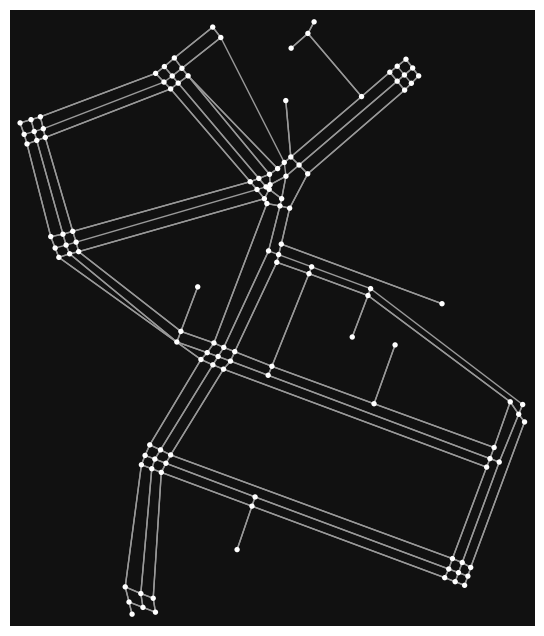

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [129]:
G_ox = ox.graph_from_address('81-63 Lefferts Blvd, Kew Gardens, NY 11415',dist=200.0,simplify=True)
for n1, n2, d in G_ox.edges(data=True):
    d.pop('geometry', None)
print(G_ox)
ox.plot_graph(G_ox)

In [70]:
G_ox_gdf = ox.graph_to_gdfs(G_ox)

In [55]:
G_ox_adb = nxadb.MultiDiGraph(name="Kew_and_Willow",
                                db=db,
                                incoming_graph_data=G_ox,
                                overwrite_graph=True)

print(G_ox_adb)

[19:10:16 -0500] [INFO]: Graph 'Kew_and_Willow' created.
[2025/02/25 19:10:16 -0500] [19918] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/02/25 19:10:16 -0500] [19918] [INFO] - adbnx_adapter: Created ArangoDB 'Kew_and_Willow' Graph


MultiDiGraph named 'Kew_and_Willow' with 47 nodes and 132 edges


In [56]:
print(G_ox.number_of_edges())
print(G_ox_adb.number_of_edges())

132
132


In [57]:
arango_graph = ArangoGraph(db)

In [122]:
import os
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'stop', 'logprobs': None}, id='run-15140271-9fe0-43fa-8320-ade1efa4e21e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [123]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

In [124]:
# 5. Define the Text to OSMNX/cuGraph Tool
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_ox_algorithm_to_text(query):
    """This tool is available to invoke a OSMNX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating OSMNX code")

    text_to_ox = llm.invoke(f"""
    I have an OSMNX Graph called `G_ox_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_nx_adb` object.

    Be very precise on the OSMNX algorithm you select to answer this query. Think step by step.

    Only assume that OSMNX and NetworkX are  installed, and other base python dependencies.

    Each node of the OSMNX graph has an X and Y attribute representing latitude and longitude.

    When referencing the OSMNX or NetworkX libraries, import them as ox and nx.

    If the query references visualizing or plotting the graph, only generate code using the OSMNX plot_graph() function.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_ox_cleaned = re.sub(r"^```python\n|```$", "", text_to_ox, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_ox_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing OSMNX code")
    global_vars = {"G_adb": G_adb, "ox": ox}
    local_vars = {}

    try:
        exec(text_to_ox_cleaned, global_vars, local_vars)
        text_to_ox_final = text_to_ox
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    ox_to_text = llm.invoke(f"""
        I have a OSMNX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_ox_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return ox_to_text

In [ ]:
@tool
def text_to_ox_algorithm_to_folium(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating OSMNX code")

    text_to_ox = llm.invoke(f"""
    I have an OSMNX Graph called `G_ox_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_nx_adb` object.

    Be very precise on the OSMNX algorithm you select to answer this query. Think step by step.

    Only assume that OSMNX, Pandas, and NetworkX are  installed, and other base python dependencies.

    Each node of the OSMNX graph has an X and Y attribute representing latitude and longitude.

    When referencing the OSMNX or NetworkX libraries, import them as ox and nx.

    If the query references visualizing or plotting the graph, only generate code using the OSMNX plot_graph() function.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_ox_cleaned = re.sub(r"^```python\n|```$", "", text_to_ox, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_ox_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing OSMNX code")
    global_vars = {"G_adb": G_adb, "ox": ox}
    local_vars = {}

    try:
        exec(text_to_ox_cleaned, global_vars, local_vars)
        text_to_ox_final = text_to_ox
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    ox_to_df = llm.invoke(f"""
        I have a OSMNX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_ox_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, create a Python dictionary with the keys 'lat' and 'long'. 
        Fill in the dictionary with the correct lat and long values specified by the query.
        Always set this variable as `
        Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.
    """).content

        text_to_df_cleaned = re.sub(r"^```python\n|```$", "", text_to_ox, flags=re.MULTILINE).strip()
        global_vars = {"G_adb": G_adb, "ox": ox}
        local_vars = {}
    
        try:
            exec(text_to_ox_cleaned, global_vars, local_vars)
            text_to_ox_final = text_to_ox
        except Exception as e:
            print(f"EXEC ERROR: {e}")
            return f"EXEC ERROR: {e}"
    
            # TODO: Consider experimenting with a code corrector!
            attempt = 1
            MAX_ATTEMPTS = 3
    
            # while attempt <= MAX_ATTEMPTS
                # ...
    
        print('-'*10)
        FINAL_RESULT = local_vars["FINAL_RESULT"]
        print(f"FINAL_RESULT: {FINAL_RESULT}")
        print('-'*10)
    
    df = pd.DataFrame(data)
    map_1 = KeplerGl(map

    return ox_to_text

In [125]:
# 6. Create the Agentic Application

# Note: Consider implementing a hybrid tool that combines both AQL & NetworkX Algorithms!

tools = [text_to_aql_to_text, text_to_ox_algorithm_to_text]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [120]:
query_graph("What LLM are you?")

"I am based on OpenAI's GPT-3 model, which is a large language model (LLM) designed to understand and generate human-like text based on the input it receives. My capabilities include answering questions, providing explanations, and assisting with a variety of tasks. How can I assist you today?"

In [178]:

coords = [(45.843080, -74.392429), (-87.104860, -167.890659)]
map = folium.Map()
for point in coords:
    folium.Marker(point).add_to(map)
map